<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 4096)
(400, 64, 64)
(400,)
<class 'str'>


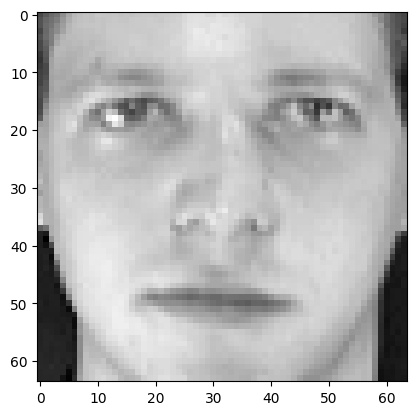

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
print(type(data))
print(data.keys())
dataes = data.data
print(dataes.shape) # 400 images, 4096 pixels
images = data.images
print(images.shape) # 400 images, 64x64 pixels
target = data.target
print(target.shape) # 400 images, 64x64 pixels
DESCR = data.DESCR
print(type(DESCR)) # strings 
img = np.uint8(data.images[0] * 255)

plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
dataes = data.data
print(dataes.shape) # 400 images, 4096 pixels
images = data.images
print(images.shape) # 400 images, 64x64 pixels
target = data.target
print(target.shape) # 400 images, 64x64 pixels


<class 'numpy.ndarray'>
<class 'numpy.float32'>


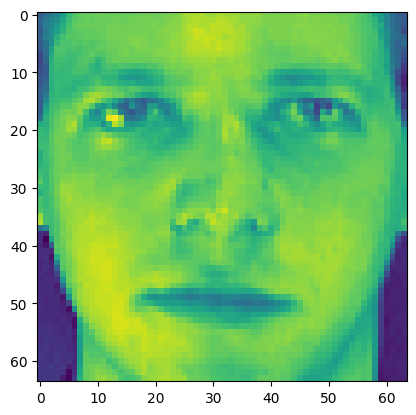

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class olive_datasets(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data[index]
        target = self.target[index]
        return data, target

train_data = olive_datasets(images, target)

print(type(train_data[0][0]))
print(type(train_data[0][0][0][0])) # float 32 = 4bytes
plt.imshow(train_data[0][0])
plt.show()

class olive_dataloader(Dataset):
    def __inint__(self, data, target):
        self.data = data
        self.target = target

torch.Size([32, 64, 64])
torch.Size([32])
tensor(33)


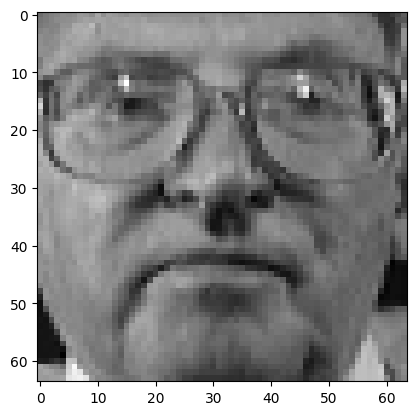

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader

class OlivettiFacesDataset(Dataset):
    def __init__(self):
        data = fetch_olivetti_faces()
        self.images = data.images
        self.target = data.target

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        target = self.target[index]
        return image, target

dataloader = DataLoader(OlivettiFacesDataset(), batch_size=32, shuffle=True,drop_last=True, num_workers=4)
for image, target in dataloader:
    print(image.shape)
    print(target.shape)
    print(target[0])
    plt.imshow(image[0], cmap='gray')
    
    break


In [ ]:

class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # process a label of shape (H, W, NC)
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # make channel first
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label